# Sample a probability density with Neal's funnel using HMC

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from jax import jit, vmap
import jax.numpy as jnp
import jax.random as jr
import jax.scipy as js

import numpyro
import numpyro.distributions as dist

import torch
import zuko
import random
import pyro
from pyro import distributions as pyro_dist

from corner import corner

We model parameters $\mathbf{x}$ and $y$ where take $\mathbf{x}\in\mathbb{R}^n$ and $y\in\mathbb{R}$. The joint posterior probability density for some observed data $d$ is

\begin{equation*}
    p(\mathbf{x}, y | d) \propto p(d | \mathbf{x}) \cdot p(\mathbf{x} | y) \cdot p(y)\,.
\end{equation*}

with distributions

\begin{equation*}
    p(d | x_i) \sim \text{Laplace}(\mu=\mu_i, b=b_i)\,,
\end{equation*}

\begin{equation*}
    p(\mathbf{x} | y) \sim \mathcal{N}(\boldsymbol{\mu}=\mathbf{0}, \Sigma=e^{y}\,\mathbf{I})\,,
\end{equation*}

\begin{equation*}
    p(y) \sim \text{Cauchy}(x_0=0, \gamma=1)\,.
\end{equation*}

In [2]:
# dimension of x parameter
x_dim = 5

# characterize likelihood
mu_key, b_key = jr.split(jr.key(0))
Laplace_mus = jr.uniform(key=mu_key,
                 shape=(x_dim,),
                 minval=-1.,
                 maxval=1.)
Laplace_bs = jr.uniform(key=b_key,
                shape=(x_dim,),
                minval=5.,
                maxval=10.)

# characterize prior on y
Cauchy_x0 = 0.
Cauchy_gamma = 0.5

In [3]:
# likelihood
@jit
def lnlike(x):
    return jnp.sum(js.stats.laplace.logpdf(x, loc=Laplace_mus, scale=Laplace_bs))

# prior on x
@jit
def x_lnprior(x, y):
    return js.stats.multivariate_normal.logpdf(x=x,
                                               mean=jnp.zeros(x_dim),
                                               cov=jnp.eye(x_dim)*jnp.exp(y))

# prior on y
@jit
def y_lnprior(y):
    return js.stats.cauchy.logpdf(x=y,
                                  loc=Cauchy_x0,
                                  scale=Cauchy_gamma)

# prior on y using torch for later
torch_Cauchy = torch.distributions.Cauchy(loc=Cauchy_x0, scale=Cauchy_gamma)
def y_lnprior_torch(y):
    return torch_Cauchy.log_prob(y)

# posterior
@jit
def lnpost(x, y):
    return lnlike(x) + x_lnprior(x, y) + y_lnprior(y)

In [4]:
# sample funnel with HMC
def neals_funnel():
    x = numpyro.sample('x', dist.Uniform(-1000., 1000.).expand((x_dim,)))
    y = numpyro.sample('y', dist.Uniform(-1000., 1000.))
    numpyro.factor('lnpost', lnpost(x, y))

nuts_kernel = numpyro.infer.NUTS(neals_funnel,
                                 dense_mass=True)
mcmc = numpyro.infer.MCMC(sampler=nuts_kernel,
                          num_warmup=int(1e4),
                          num_samples=int(1e4))
mcmc.run(jr.key(0))
samples_dict = mcmc.get_samples()
samples = np.concatenate((samples_dict['x'],
                          samples_dict['y'][:, None]),
                          axis=1)

sample: 100%|██████████| 20000/20000 [00:05<00:00, 3879.53it/s, 7 steps of size 3.43e-01. acc. prob=0.88] 


In [60]:
# standardize funnel for better sampling
def neals_funnel_standardized():
    x_standard = numpyro.sample('x_standard', dist.Normal().expand((x_dim,)))
    y = numpyro.sample('y', dist.Cauchy(loc=Cauchy_x0, scale=Cauchy_gamma))
    # y = numpyro.sample('y', dist.Uniform(-100., 10.))
    x = x_standard * jnp.exp(y / 2)
    numpyro.deterministic('x', x)
    numpyro.factor('lnlike', lnlike(x))

nuts_kernel_st = numpyro.infer.NUTS(neals_funnel_standardized,
                                    dense_mass=True)
mcmc_st = numpyro.infer.MCMC(sampler=nuts_kernel_st,
                             num_warmup=int(1e4),
                             num_samples=int(1e6))
mcmc_st.run(jr.key(1))
samples_dict_st = mcmc_st.get_samples()
samples_st = np.concatenate((samples_dict_st['x'],
                             samples_dict_st['y'][:, None]),
                             axis=1)

sample: 100%|██████████| 1010000/1010000 [03:03<00:00, 5500.24it/s, 31 steps of size 1.20e-01. acc. prob=0.87]


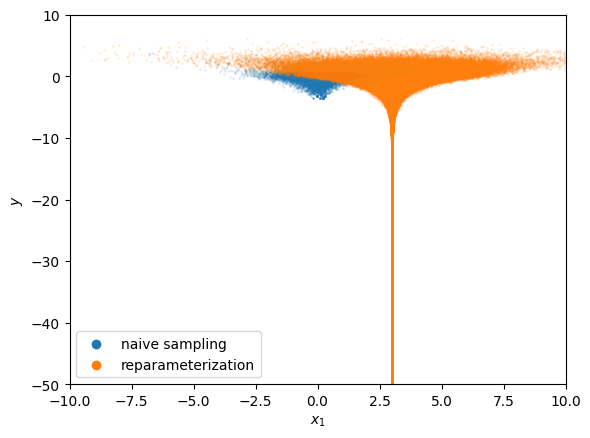

In [150]:
# plot samples
ndx1 = 0
ndx2 = -1
x_labels = np.array([rf'$x_{{{i}}}$' for i in np.arange(1, x_dim + 1)])
labels = np.concatenate((x_labels, np.array([r'$y$'])))
plt.scatter(samples[:, ndx1], samples[:, ndx2], s=1, alpha=0.1)
plt.scatter(3 + samples_st[:, ndx1], samples_st[:, ndx2], s=1, alpha=0.1)
plt.scatter([], [], color='C0', label='naive sampling')
plt.scatter([], [], color='C1', label='reparameterization')
plt.xlim(-200, 750)
plt.xlabel(labels[ndx1])
plt.ylabel(labels[ndx2])
plt.xlim(-10, 10)
plt.ylim(-50, 10)
plt.legend()
plt.show()

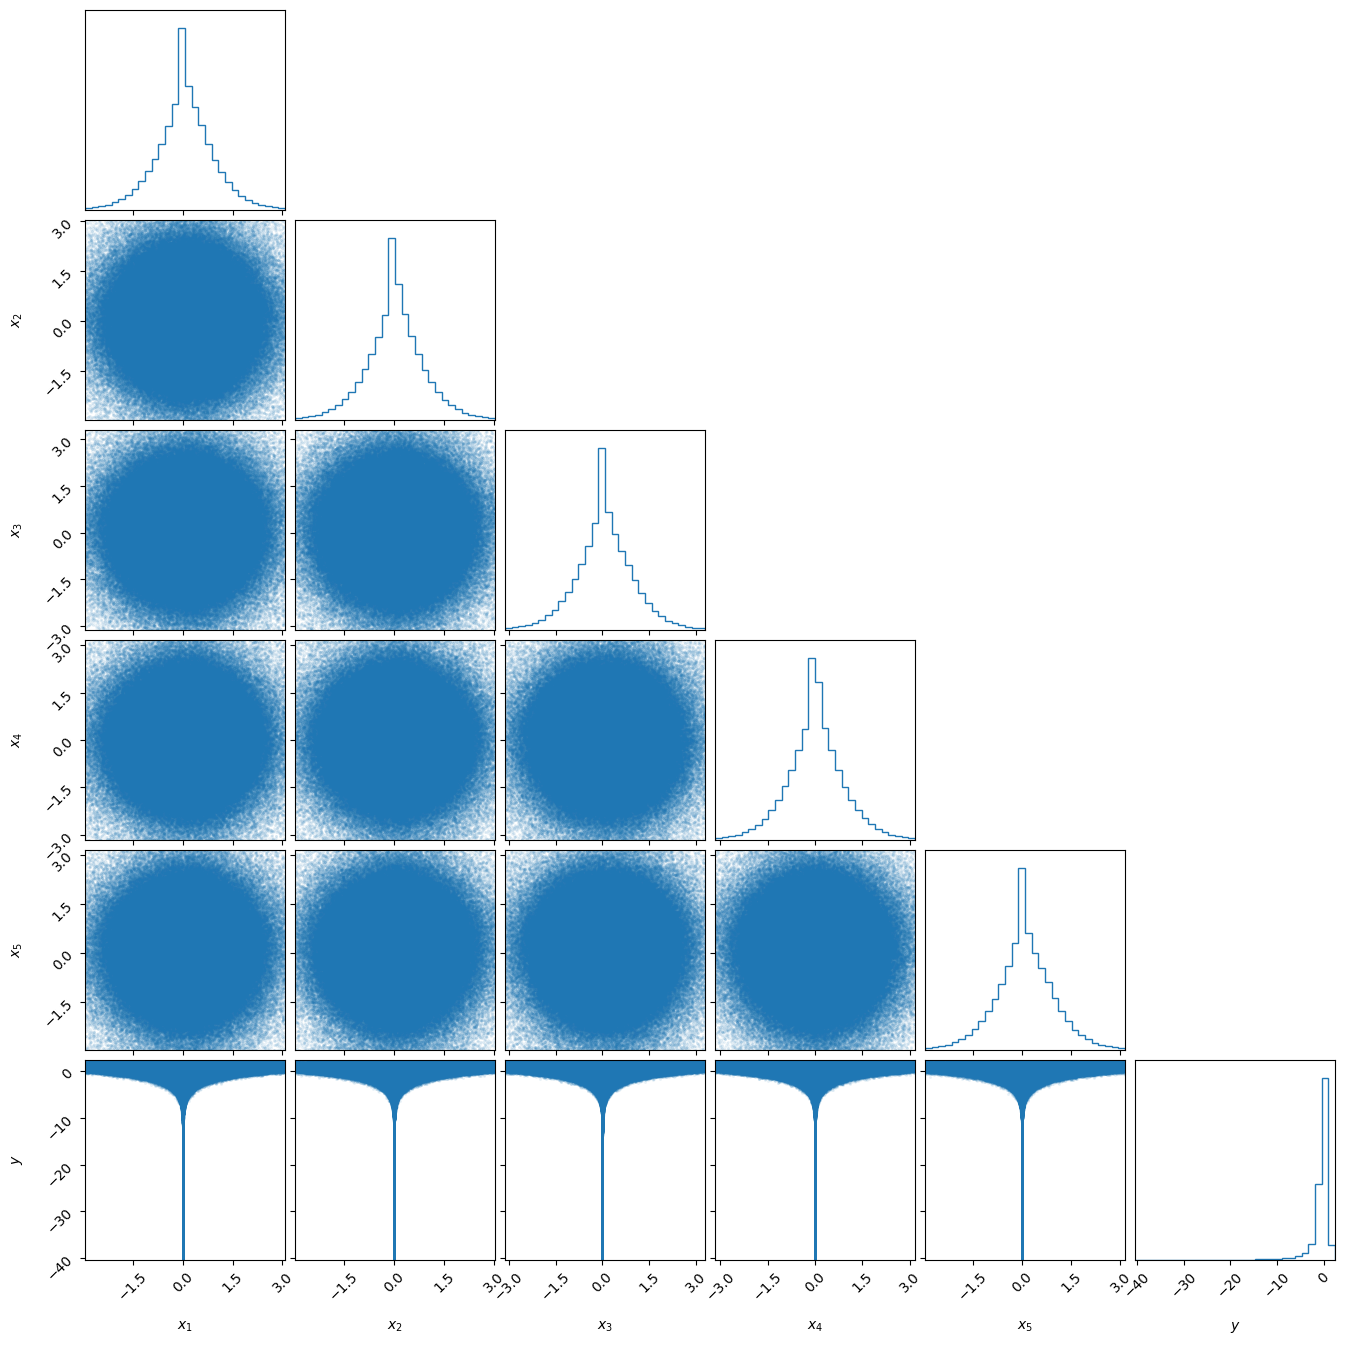

In [74]:
fig = corner(samples_st,
             labels=labels,
             range=[0.99]*samples_st.shape[1],
             color='C0',
             plot_contours=False,
             plot_density=False,
             bins=30)

(-10.0, 8.0)

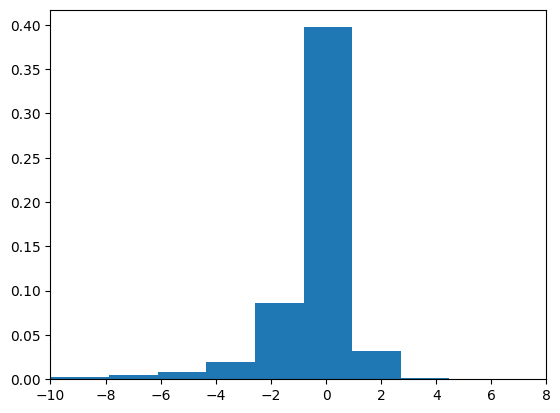

In [63]:
plt.hist(samples_st[:, -1], bins=1000, density=True)
plt.xlim(-10, 8)

In [91]:
import numpy as np

def _default_bandwidth(t):
    """Silverman-ish rule of thumb for 1D bandwidth."""
    t = np.asarray(t)
    n = t.size
    if n < 2:
        return 1.0
    std = np.std(t, ddof=1)
    # Silverman: 1.06 * sigma * n^{-1/5}
    return 1.06 * std * n ** (-1/5)

def compute_conditional_covariances(samples,
                                    query_points=None,
                                    bandwidth=None,
                                    kernel='gaussian',
                                    return_means=False,
                                    batch_size=1000,
                                    eps=1e-12):
    """
    Compute covariances of all-but-last parameters as a function of the last parameter.
    
    Parameters
    ----------
    samples : ndarray, shape (n, p)
        MCMC samples; last column is the conditioning variable t.
    query_points : array_like or None
        Values of the last parameter at which to estimate the covariance.
        If None, uses the unique sorted last-sample values (can be large).
        You may want to provide a smaller grid for efficiency.
    bandwidth : float or None
        Kernel bandwidth in the last-parameter space. If None uses a rule-of-thumb.
    kernel : {'gaussian'}
        Kernel type. Currently only gaussian is implemented.
    return_means : bool
        If True also return the conditional means (m, d).
    batch_size : int
        Number of query points to process per batch (to save memory).
    eps : float
        Small floor for sum-of-weights to avoid division by zero.
    
    Returns
    -------
    covs : ndarray, shape (m, d, d)
        Conditional covariance matrices at each query point.
    means : ndarray, shape (m, d) (only if return_means=True)
        Conditional weighted means.
    """
    samples = np.asarray(samples)
    if samples.ndim != 2:
        raise ValueError("samples must be 2D array (n_samples, n_params)")
    n, p = samples.shape
    if p < 2:
        raise ValueError("need at least two params (one to condition on)")
    X = samples[:, :-1]        # shape (n, d)
    t = samples[:, -1]         # shape (n,)
    d = X.shape[1]
    
    if query_points is None:
        # using all sample values may be expensive; user can pass a grid
        query_points = np.unique(t)
    query_points = np.asarray(query_points, dtype=float)
    m = query_points.size
    
    if bandwidth is None:
        bandwidth = _default_bandwidth(t)
        # if std=0, fallback to small positive number
        if bandwidth == 0 or np.isnan(bandwidth):
            bandwidth = 1.0
    
    if kernel != 'gaussian':
        raise NotImplementedError("Only 'gaussian' kernel is implemented in this function.")
    
    # Prepare outputs
    covs = np.empty((m, d, d), dtype=float)
    if return_means:
        means = np.empty((m, d), dtype=float)
    else:
        means = None
    
    # process in batches to avoid creating huge (m,n) weight matrix at once
    # but for moderate m*n this will be vectorized and fast.
    for start in range(0, m, batch_size):
        stop = min(m, start + batch_size)
        qbatch = query_points[start:stop]         # shape (b,)
        # compute kernel weights W_batch[j,i] = K( (t[i] - qbatch[j]) / bw )
        # W_batch shape (b, n)
        diff = qbatch[:, None] - t[None, :]       # (b, n)
        # gaussian kernel
        W = np.exp(-0.5 * (diff / bandwidth) ** 2)
        # (optionally) you could normalize kernel amplitude by sqrt(2*pi)*bw
        # but normalization cancels out when dividing by sum_w; not required
        
        sum_w = W.sum(axis=1)                     # shape (b,)
        # avoid divide-by-zero
        small_mask = sum_w < eps
        sum_w[small_mask] = eps
        
        # compute weighted first moment: M1_j = sum_i w_ji * x_i  => shape (b, d)
        M1 = W @ X                                 # (b, d)
        mu = M1 / sum_w[:, None]                   # (b, d)
        
        # compute weighted second moment: M2_j = sum_i w_ji * (x_i outer x_i) => (b, d, d)
        # use einsum to avoid explicit loops
        M2 = np.einsum('ji,ik,il->jkl', W, X, X)   # (b, d, d)
        M2 = M2 / sum_w[:, None, None]             # normalize -> E_w[xx^T]
        
        # Cov = E_w[xx^T] - mu mu^T  (population covariance under weights)
        # if you prefer unbiased weighted covariance, adjust denominator accordingly.
        mu_outer = mu[:, :, None] * mu[:, None, :] # (b, d, d)
        C = M2 - mu_outer                           # (b, d, d)
        
        # if any sums were tiny, set cov to nan to flag it
        for j_in_batch, is_small in enumerate(small_mask):
            if is_small:
                C[j_in_batch, :, :] = np.nan
                mu[j_in_batch, :] = np.nan
        
        covs[start:stop, :, :] = C
        if return_means:
            means[start:stop, :] = mu
    
    if return_means:
        return covs, means
    return covs

In [181]:
import numpy as np
from scipy.stats import gaussian_kde

def conditional_covariance(samples, query_points, bandwidth=None):
    """
    Compute covariance of all-but-last parameters conditional on last parameter
    using a Gaussian kernel.
    """
    X = samples[:, :-1]
    t = samples[:, -1]

    # Build KDE on the last parameter to get kernel weights
    kde = gaussian_kde(t, bw_method=bandwidth)

    covs = []
    for q in np.atleast_1d(query_points):
        # Gaussian weights for each sample centered at q
        w = np.exp(-0.5 * ((t - q) / kde.factor / np.std(t))**2)
        w /= np.sum(w)

        mu = np.average(X, axis=0, weights=w)
        xc = X - mu
        cov = (w[:, None] * xc).T @ xc  # weighted covariance
        covs.append(cov)

    return np.array(covs)

In [182]:
y_vals = jnp.linspace(-10, 7.5, 100)
covs = conditional_covariance(samples_st, query_points=y_vals, bandwidth=None)
print(covs.shape)
sigmas_eff = jnp.array([jnp.sqrt(jnp.trace(cov) / x_dim) for cov in covs])

(100, 5, 5)


In [ ]:
# calculate curvature of funnel
y_vals = jnp.linspace(-6, -2, 50)
sigmas_eff = np.zeros(y_vals.shape[0] - 1)
for i, y_val in enumerate(y_vals[:-1]):
    mask = (samples_st[:, -1] > y_vals[i]) & (samples_st[:, -1] < y_vals[i + 1])
    filtered_samples = samples_st[mask]
    cov = jnp.cov(samples_st[mask, :-1].T)
    sigmas_eff[i] = jnp.sqrt(jnp.trace(cov) / x_dim)


In [204]:
stdev_index = 0
y_vals = jnp.linspace(-6, -2, 500)
sigmas = jnp.zeros(len(y_vals) - 1)

for i in range(len(y_vals) - 1):
    mask = (samples_st[:, -1] > y_vals[i]) & (samples_st[:, -1] < y_vals[i + 1])
    if jnp.any(mask):
        sigmas = sigmas.at[i].set(jnp.std(samples_st[mask, stdev_index]))
    else:
        sigmas = sigmas.at[i].set(jnp.nan)

In [205]:
def conditional_std_kde(x, y, query_points, bandwidth=None):
    """
    Compute conditional standard deviation of x given y using a Gaussian kernel.

    Parameters
    ----------
    x : array_like, shape (n,)
        Samples of the variable of interest.
    y : array_like, shape (n,)
        Samples of the conditioning variable.
    query_points : array_like
        Values of y at which to estimate std(x).
    bandwidth : float or None
        Gaussian kernel bandwidth. If None, uses Silverman's rule.

    Returns
    -------
    stds : ndarray, shape (len(query_points),)
        Conditional standard deviation of x at each query point.
    """
    x = jnp.asarray(x)
    y = jnp.asarray(y)
    query_points = jnp.asarray(query_points)

    n = len(y)
    if bandwidth is None:
        # Silverman's rule of thumb for 1D
        std_y = jnp.std(y, ddof=1)
        bandwidth = 1.06 * std_y * n ** (-1/5)

    stds = []
    for q in query_points:
        # Gaussian weights
        w = jnp.exp(-0.5 * ((y - q) / bandwidth) ** 2)
        w /= jnp.sum(w) + 1e-12  # normalize and avoid divide-by-zero

        mean_x = jnp.sum(w * x)
        var_x = jnp.sum(w * (x - mean_x) ** 2)
        stds.append(jnp.sqrt(var_x))

    return jnp.array(stds)

In [208]:
sigmas_kde = conditional_std_kde(samples_st[:, 0], samples_st[:, -1], y_vals, bandwidth=0.2)

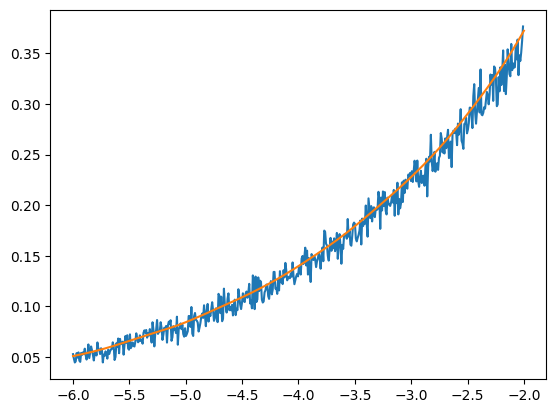

In [209]:
plt.plot(y_vals[:-1], sigmas)
plt.plot(y_vals, sigmas_kde)

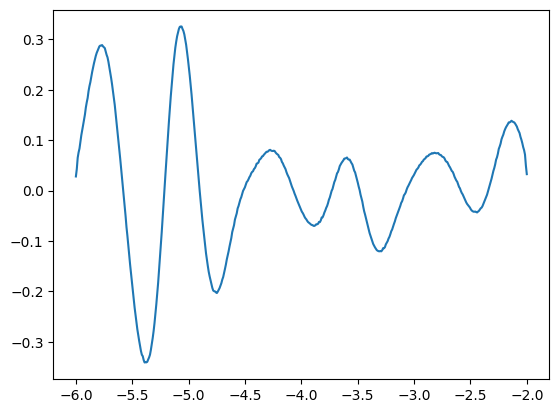

In [211]:
dsigma = np.gradient(jnp.log(sigmas_kde), y_vals)
d2sigma = np.gradient(dsigma, y_vals)
kappa = d2sigma / (1. + dsigma**2.)**(1.5)
plt.plot(y_vals, kappa)

Instead of sampling over $y$ which leads to a strong funnel, we sample the "extended" density,

\begin{equation*}
    p(\mathbf{x}, \mathbf{z} | d) \propto p(d | \mathbf{x}) \cdot p(\mathbf{x} | \mathbf{z}) \cdot p(\mathbf{z})
\end{equation*}

where $\mathbf{z}\in\mathbb{R}^n$ with

\begin{equation*}
    p(\mathbf{x} | \mathbf{z}) \sim \mathcal{N}(\mathbf{\mu}=\mathbf{0}, \Sigma=\text{diag}(\mathbf{z}))\,.
\end{equation*}

In [131]:
def extended_model():
    # sample in log(z)
    log10_z = numpyro.sample('log10_z', dist.Uniform(-10., 4.).expand((x_dim,)))
    # conditional prior on x
    x_standard = numpyro.sample('x_standard', dist.Normal().expand((x_dim,)))
    x = numpyro.deterministic('x', x_standard * jnp.sqrt(10. ** log10_z))
    # likelihood
    numpyro.factor('lnlike', lnlike(x))

nuts_kernel_extended = numpyro.infer.NUTS(extended_model,
                                          dense_mass=False)
mcmc_extended = numpyro.infer.MCMC(sampler=nuts_kernel_extended,
                                      num_warmup=int(1e4),
                                      num_samples=int(5e5))
mcmc_extended.run(jr.key(2))
samples_dict_extended = mcmc_extended.get_samples()
extended_samples = np.concatenate((samples_dict_extended['x'],
                                   samples_dict_extended['log10_z']),
                                   axis=1)

sample: 100%|██████████| 510000/510000 [01:12<00:00, 7035.69it/s, 7 steps of size 4.04e-01. acc. prob=0.80] 


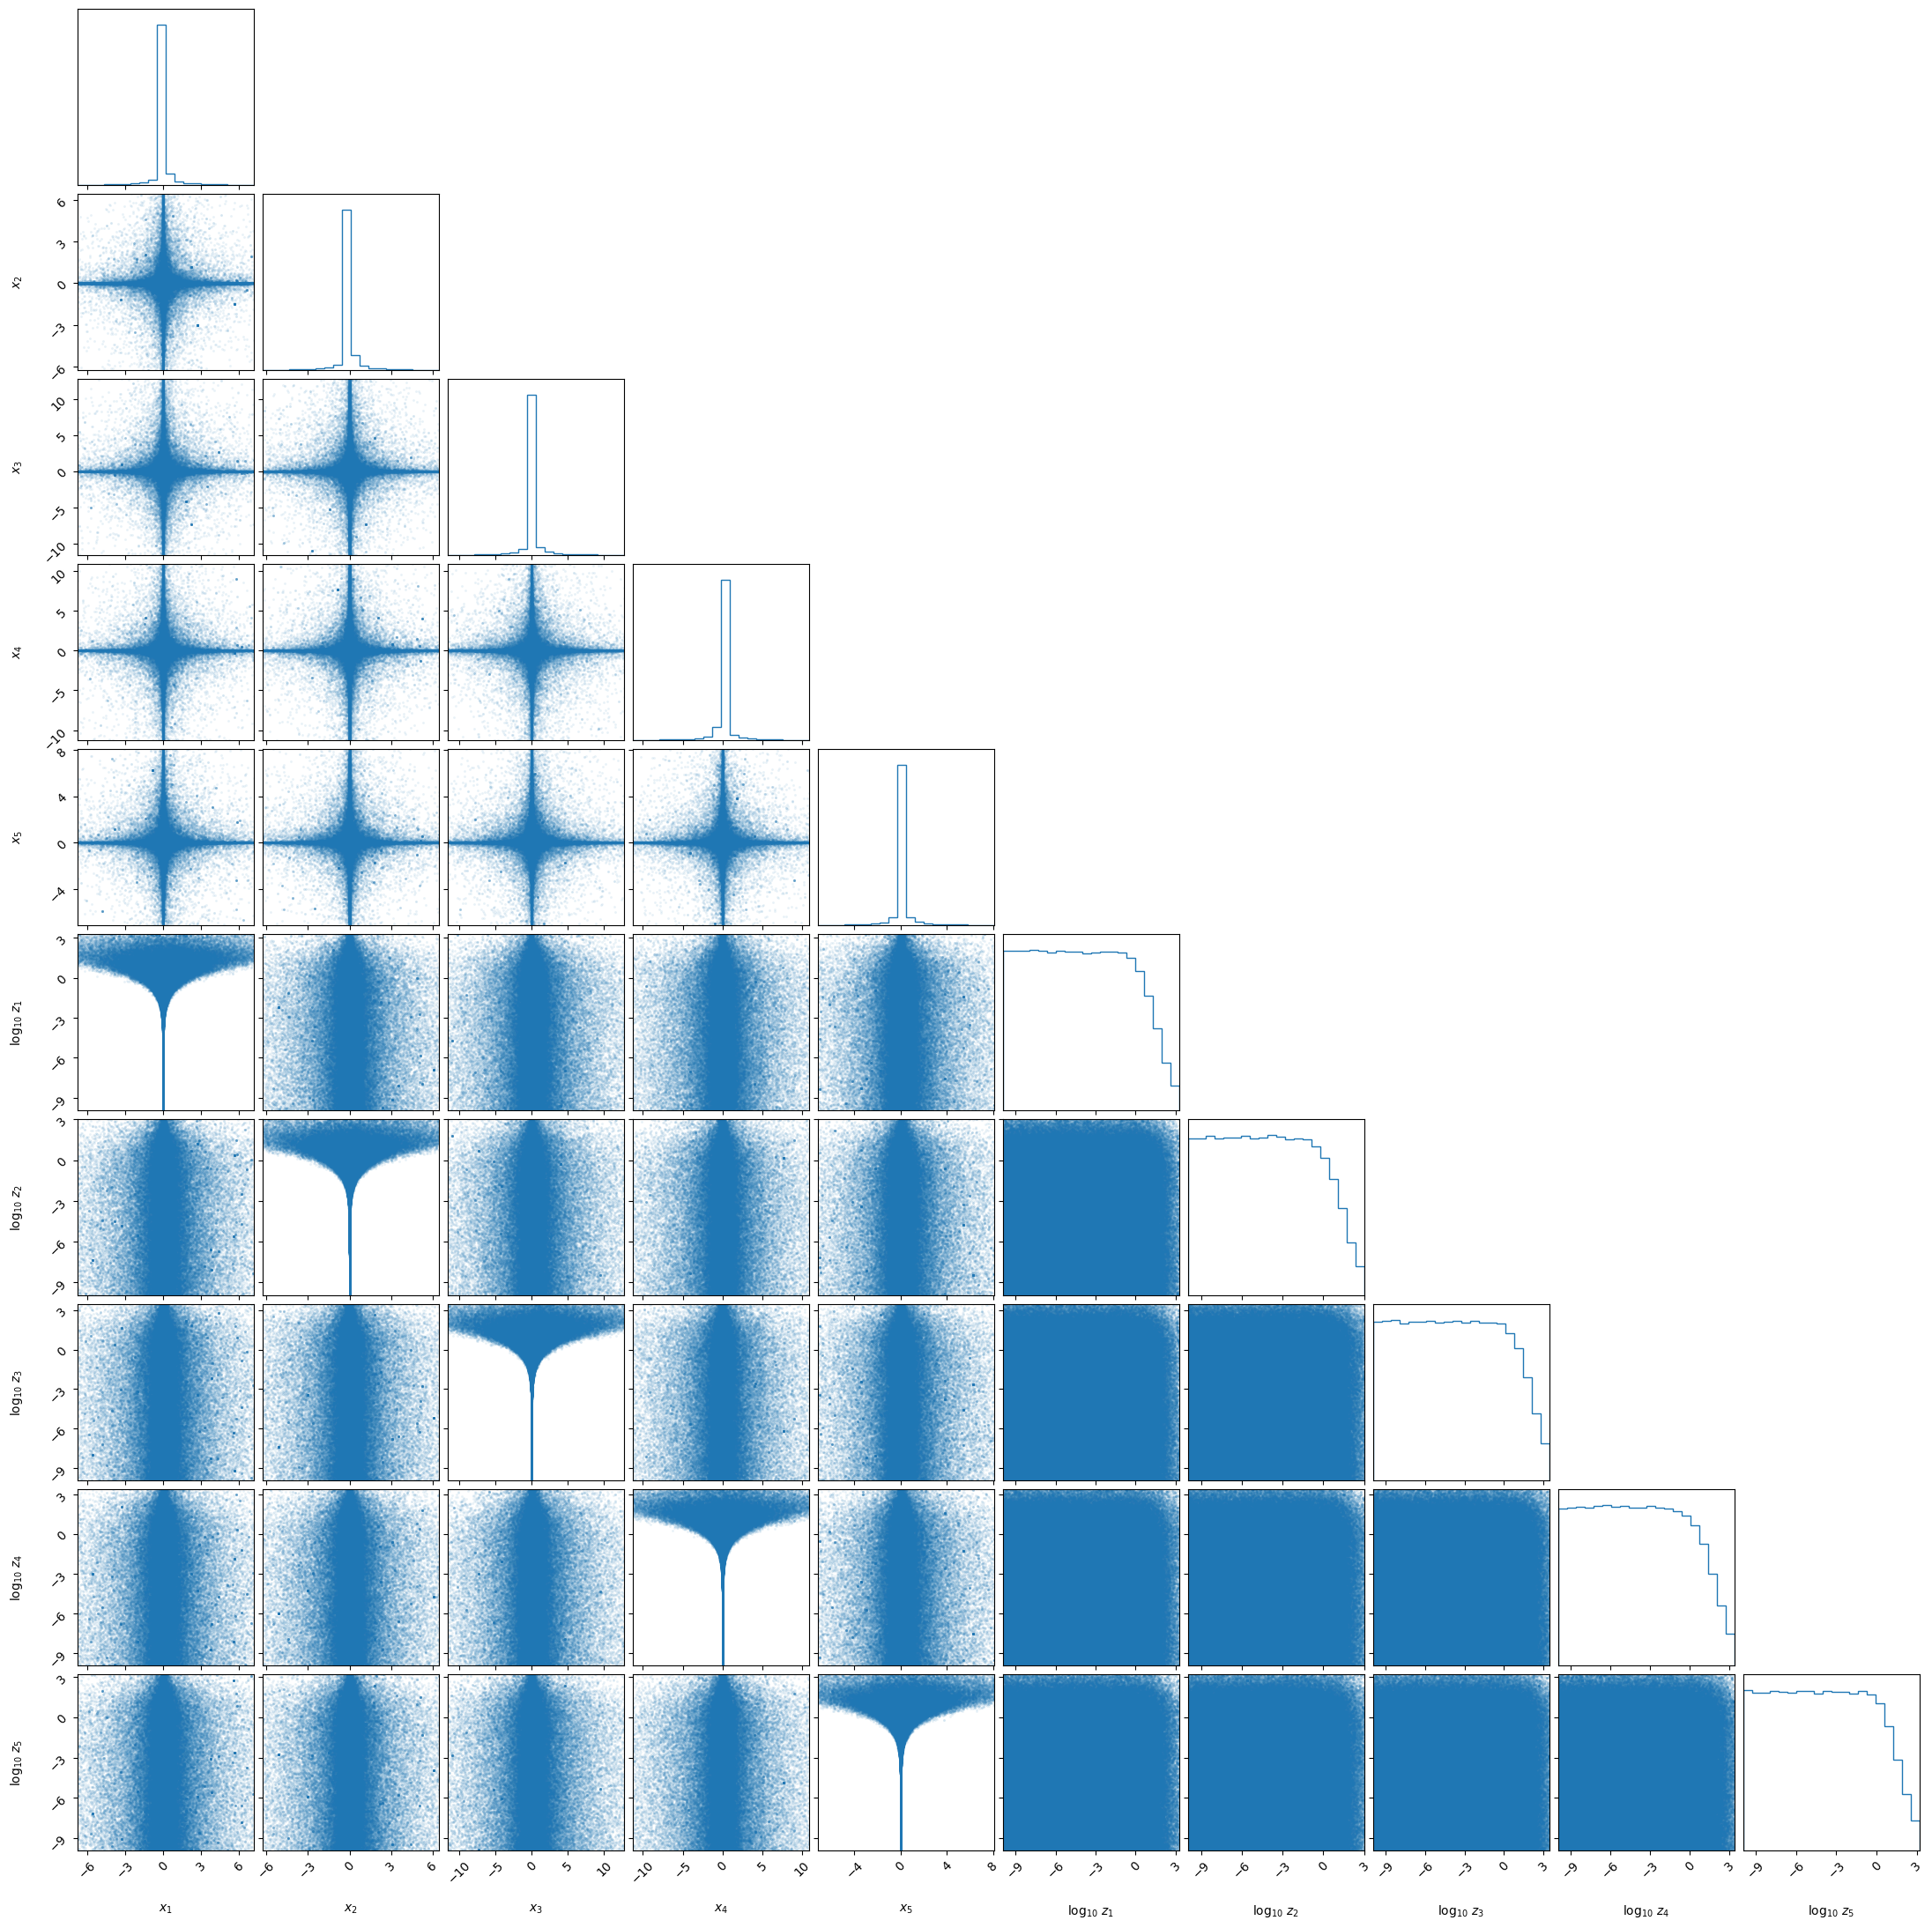

In [132]:
z_labels = np.array([rf'$\log_{{{10}}}\,z_{{{i}}}$' for i in np.arange(1, x_dim + 1)])
extended_labels = np.concatenate((x_labels, z_labels))
fig = corner(extended_samples,
             labels=extended_labels,
             range=[0.99]*extended_samples.shape[1],
             color='C0',
             plot_contours=False,
             plot_density=False,
             bins=20)

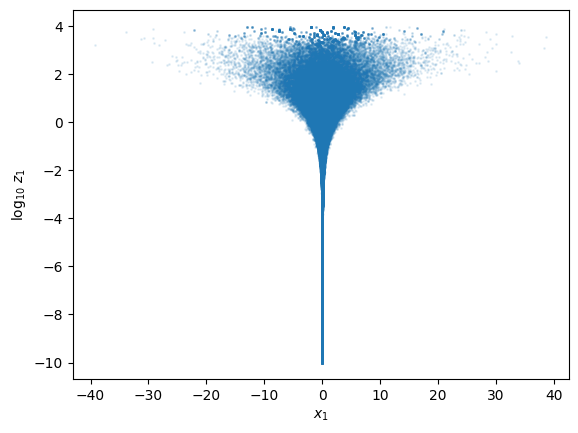

In [133]:
ndx1 = 0
ndx2 = x_dim
plt.scatter(extended_samples[:, ndx1], extended_samples[:, ndx2],
            color='C0', s=1, alpha=0.1)
plt.xlabel(extended_labels[ndx1])
plt.ylabel(extended_labels[ndx2])
plt.show()

In [212]:
log10z_vals = jnp.linspace(-6, -2, 500)
sigmas = conditional_std_kde(extended_samples[:, 0], extended_samples[:, x_dim], log10z_vals, bandwidth=0.2)

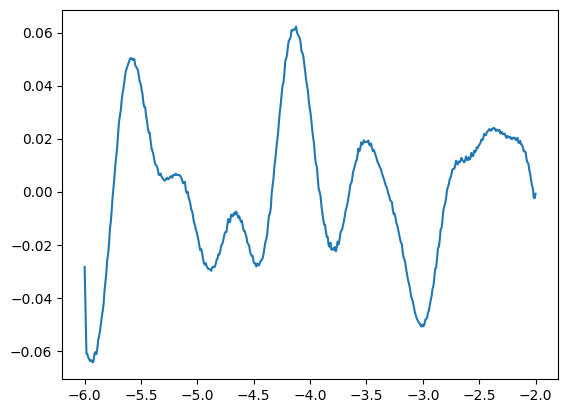

In [213]:
dsigma = np.gradient(jnp.log(sigmas), log10z_vals)
d2sigma = np.gradient(dsigma, log10z_vals)
kappa = d2sigma / (1. + dsigma**2.)**(1.5)
plt.plot(log10z_vals, kappa)